In [4]:
# CNN 모듈 (위/경도 처리)
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 10 * 7, 128)  # Input을 적절히 Flatten하여 Linear Layer에 전달
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply convolutional layers
        x = self.pool(self.relu(self.conv1(x)))  # (N, 1, 43, 28) -> (N, 32, 21, 14)
        x = self.pool(self.relu(self.conv2(x)))  # (N, 32, 21, 14) -> (N, 64, 10, 7)

        # Flatten the output of the conv layers
        x = x.view(-1, 64 * 10 * 7)  # Flatten: (N, 64, 10, 7) -> (N, 64 * 10 * 7)

        # Fully connected layer
        x = self.relu(self.fc1(x))  # (N, 64 * 10 * 7) -> (N, 128)
        return x

# MLP 모듈 (정형 데이터 처리: 금리, 면적 등)
class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = x.squeeze(1)
        return x

# 결합 모델 (CNN + MLP)
class CombinedModel(nn.Module):
    def __init__(self, input_size):
        super(CombinedModel, self).__init__()
        self.cnn = CNNModel()
        self.mlp = MLPModel(input_size)
        self.fc = nn.Linear(128+128, 1)  # CNN과 MLP의 출력 크기를 합친 후 최종 예측

    def forward(self, x_cnn, x_mlp):
        cnn_out = self.cnn(x_cnn)  # CNN 처리 (위/경도)
        mlp_out = self.mlp(x_mlp)  # MLP 처리 (정형 데이터)

        combined = torch.cat((cnn_out, mlp_out), dim=1)  # 두 출력을 결합

        out = self.fc(combined)  # 최종 예측 (전세가)
        return out

In [1]:
from utils.datasets import *
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

def train(model, train_loader, loss_fn, optimizer, epochs, device, losses):

    # train 모드로 설정
    model.train()

    for epoch in tqdm(range(epochs)):
        epoch_loss = 0.0
        for batch in tqdm(train_loader):
            X_cnn,X_mlp, y = batch
            X_cnn, X_mlp, y = X_cnn.to(device), X_mlp.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = model(X_cnn, X_mlp)
            loss = criterion(y_pred,y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

def validate(model, valid_loader, device):
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            X_cnn, X_mlp, y = batch
            X_cnn, X_mlp, y = X_cnn.to(device), X_mlp.to(device), y.to(device)
            
            output = model(X_cnn, X_mlp)
            
            # 예측값을 numpy로 변환하고 (batch_size, 1) 형태로 조정 후 리스트에 저장
            all_preds.append(output.cpu().numpy().reshape(-1, 1))
            all_targets.append(y.cpu().numpy().reshape(-1, 1))  # 실제값도 같은 형태로 저장

    # 전체 데이터를 (len(valid), 1) 형태의 numpy 배열로 변환
    all_preds = np.vstack(all_preds)  # 세로로 쌓아서 (len(valid), 1) 배열 생성
    all_targets = np.vstack(all_targets)  # 실제값도 같은 방식으로 변환

    # MAE 계산
    mae_score = mean_absolute_error(all_targets, all_preds)
    print(f'\nMAE Score: {mae_score:.4f}')
    return mae_score

def inference_test(model, test_loader, device):
    model.to(device)
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            X_cnn, X_mlp = batch
            X_cnn, X_mlp = X_cnn.to(device), X_mlp.to(device)

            y_pred = model(X_cnn, X_mlp)
            all_preds.append(y_pred.cpu().numpy().reshape(-1,1))
            
        output = np.vstack(all_preds)

    return output



In [2]:
from utils.datasets import CombinedDataset
from torch.utils.data import DataLoader

train_set = CombinedDataset(mode='train')
valid_set = CombinedDataset(mode='valid')
test_set = CombinedDataset(mode='test')

train_loader = DataLoader(dataset=train_set, batch_size = 64, shuffle=False)
valid_loader = DataLoader(dataset=valid_set, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)

X.shape: torch.Size([1515867, 43, 28]), train_data_ length: 1515867


1515867it [02:06, 11959.94it/s]
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/utils/datasets.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/utils/datasets.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)


clustering apply ...
start to cleaning outliers...
train, valid, test split for preprocessing & feature engineering ...
start to preprocessing...


/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/preprocessing.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].map(map_dict).astype('category')


start to feature engineering...
create clustering features


/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clustering_features.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = kmeans.predict(test_data[['latitude', 'longitude']])
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clustering_features.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = test_data['cluster'].astype('category')
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clusteri

create distance features
create other features
create count features
Loading pre-calculated transaction data for 3 months.
standardization...


198549it [00:16, 12047.34it/s]
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/utils/datasets.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/utils/datasets.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)


clustering apply ...
start to cleaning outliers...
train, valid, test split for preprocessing & feature engineering ...
start to preprocessing...


/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/preprocessing.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].map(map_dict).astype('category')


start to feature engineering...
create clustering features


/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clustering_features.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = kmeans.predict(test_data[['latitude', 'longitude']])
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clustering_features.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = test_data['cluster'].astype('category')
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clusteri

create distance features
create other features
create count features
Loading pre-calculated transaction data for 3 months.
standardization...


150172it [00:12, 11918.98it/s]
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/utils/datasets.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)


clustering apply ...
start to cleaning outliers...
train, valid, test split for preprocessing & feature engineering ...
start to preprocessing...


/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/preprocessing.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].map(map_dict).astype('category')


start to feature engineering...
create clustering features


/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clustering_features.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = kmeans.predict(test_data[['latitude', 'longitude']])
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clustering_features.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = test_data['cluster'].astype('category')
/data/ephemeral/home/jaeeun/level2-competitiveds-recsys-01/code/features/clusteri

create distance features
create other features
create count features
Loading pre-calculated transaction data for 3 months.
standardization...


In [11]:
mlp_input = len(train_set.mlp[0][0][0])
print("feature 수 : ", mlp_input)

# batch 단위로 학습
device = 'cuda'

model = CombinedModel(mlp_input).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
losses = []

feature 수 :  36


In [12]:
train(model = model, train_loader= train_loader, loss_fn = criterion, optimizer = optimizer, epochs = epochs, device = device, losses = losses)

  1%|          | 1/100 [01:27<2:23:54, 87.22s/it]

Epoch 1, Loss: 222072585.99865723


  2%|▏         | 2/100 [02:54<2:22:14, 87.09s/it]

Epoch 2, Loss: 186963191.78479004


  3%|▎         | 3/100 [04:21<2:20:40, 87.02s/it]

Epoch 3, Loss: 181932880.78964233


  4%|▍         | 4/100 [05:48<2:19:23, 87.12s/it]

Epoch 4, Loss: 179127008.4472046


  5%|▌         | 5/100 [07:15<2:18:01, 87.17s/it]

Epoch 5, Loss: 177106999.3408203


  6%|▌         | 6/100 [08:42<2:16:36, 87.20s/it]

Epoch 6, Loss: 175732214.7052002


  7%|▋         | 7/100 [10:10<2:15:10, 87.21s/it]

Epoch 7, Loss: 174490581.96426392


  8%|▊         | 8/100 [11:37<2:13:49, 87.28s/it]

Epoch 8, Loss: 172506241.40719604


  9%|▉         | 9/100 [13:05<2:12:29, 87.36s/it]

Epoch 9, Loss: 169370388.08114624


 10%|█         | 10/100 [14:32<2:11:08, 87.43s/it]

Epoch 10, Loss: 167706411.50506592


 11%|█         | 11/100 [16:00<2:09:41, 87.43s/it]

Epoch 11, Loss: 166663524.61187744


 12%|█▏        | 12/100 [17:27<2:08:11, 87.40s/it]

Epoch 12, Loss: 165871921.71347046


 13%|█▎        | 13/100 [18:55<2:06:51, 87.49s/it]

Epoch 13, Loss: 165453037.07666016


 14%|█▍        | 14/100 [20:22<2:05:21, 87.46s/it]

Epoch 14, Loss: 165007194.94766235


 15%|█▌        | 15/100 [21:49<2:03:45, 87.36s/it]

Epoch 15, Loss: 164397314.5742798


 16%|█▌        | 16/100 [23:17<2:02:23, 87.42s/it]

Epoch 16, Loss: 163825131.92730713


 17%|█▋        | 17/100 [24:44<2:00:55, 87.41s/it]

Epoch 17, Loss: 163318251.44381714


 18%|█▊        | 18/100 [26:12<1:59:28, 87.42s/it]

Epoch 18, Loss: 162866280.27157593


 19%|█▉        | 19/100 [27:39<1:57:56, 87.36s/it]

Epoch 19, Loss: 162369190.33258057


 20%|██        | 20/100 [29:06<1:56:26, 87.33s/it]

Epoch 20, Loss: 161881720.84951782


 21%|██        | 21/100 [30:33<1:54:57, 87.31s/it]

Epoch 21, Loss: 161226927.89904785


 22%|██▏       | 22/100 [32:00<1:53:22, 87.21s/it]

Epoch 22, Loss: 160771091.37542725


 23%|██▎       | 23/100 [33:28<1:51:56, 87.23s/it]

Epoch 23, Loss: 160440048.7347107


 24%|██▍       | 24/100 [34:55<1:50:30, 87.25s/it]

Epoch 24, Loss: 160035276.67156982


 25%|██▌       | 25/100 [36:22<1:49:00, 87.21s/it]

Epoch 25, Loss: 159606521.8881836


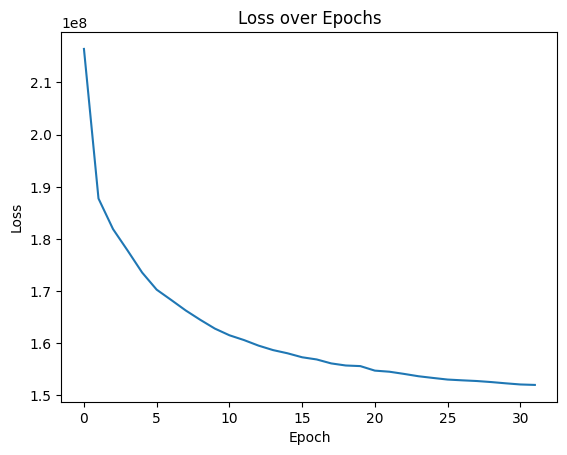

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(32), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

In [ ]:
train(model = model, train_loader= train_loader, loss_fn = criterion, optimizer = optimizer, epochs = epochs, device = device, losses = losses)

AttributeError: module 'model' has no attribute 'train'

In [ ]:
plt.plot(range(1, epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

In [ ]:
# validation score
mae = validate(model=model, valid_loader=valid_loader, device=device)